In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

import matplotlib as mpl
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

!pip install cvxpy
import cvxpy as cp

!pip install ortools==9.3.10459

     |████████████████████████████████| 2.8 MB 3.1 MB/s 
     |████████████████████████████████| 295 kB 59.4 MB/s 
     |████████████████████████████████| 10.7 MB 40.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
(CVXPY) May 16 10:40:31 AM: Encountered unexpected exception importing solver GLOP:
AttributeError("module 'ortools' has no attribute '__version__'")
(CVXPY) May 16 10:40:31 AM: Encountered unexpected exception importing solver PDLP:
AttributeError("module 'ortools' has no attribute '__version__'")
     |████████████████████████████████| 15.6 MB 3.1 MB/s 
     |████████████████████████████████| 1.0 MB 47.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
  Attempting uninstall: ortools
    Found existing installation: ortools 9.1.9490
    Uninstalling ortools-9.1.9490:
      Successfully uninstalled ortools-9.1.9490
ERROR: pip's dependency 

In [2]:
# log
def log(msg):
    now = datetime.strftime(datetime.now(tz=pytz.timezone('Hongkong')), '%Y-%m-%d %H:%M:%S')
    print(f'[{now}] {msg}')
    
# pickle
def save_pkl(obj, filename):
    pickle.dump(obj, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    return
def load_pkl(filename):
    return pickle.load(open(filename, 'rb'))

def get_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def dl_txt(full_path):
    copyfile(full_path, full_path.split('/')[-1])
    print(f"Copied {full_path.split('/')[-1]}")
    return

def clear_output():
    for file in os.listdir():
        os.remove(file)
    return

fig_num = 0
def new_plot():
    global fig_num
    fig_num += 1
    plt.figure(fig_num)
    
import signal as signal_
class TimeoutException(Exception):   # Custom exception class
    pass
def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException
signal_.signal(signal_.SIGALRM, timeout_handler)

# function to remove any rows/columns with all NaN
def df_drop_na(df):
    df = df.loc[lambda x: x.notnull().sum(axis=1) > 0]
    df = df[df.notnull().sum(axis=0).loc[lambda x: x>0].index.tolist()]
    return df

def s_drop_na(s):
    return s.loc[lambda x: x.notnull()]

def align_index(dfs):
    for i in range(len(dfs)):
        if i==0:
            idx, col = dfs[i].index, dfs[i].columns
        else:
            idx, col = idx & dfs[i].index, col & dfs[i].columns
    idx, col = idx.sort_values().tolist(), col.sort_values().tolist()
    new_dfs = tuple([df.reindex(index=idx, columns=col) for df in list(dfs)])
    return new_dfs

def align_row_index(dfs):
    for i in range(len(dfs)):
        if i==0:
            idx = dfs[i].index
        else:
            idx = idx.intersection(dfs[i].index)
    idx = idx.sort_values().tolist()
    new_dfs = tuple([df.reindex(index=idx) for df in list(dfs)])
    return new_dfs

def align_col_index(dfs):
    for i in range(len(dfs)):
        if i==0:
            col = dfs[i].columns
        else:
            col = col.intersection(dfs[i].columns)
    col = col.sort_values().tolist()
    new_dfs = tuple([df.reindex(columns=col) for df in list(dfs)])
    return new_dfs

In [3]:
# params
bt_start_date = '2014-01-01' # bt - back testing
bt_end_date = '2018-03-27'
seed = 0
h = '12m'
horizons = {'6m':21*6, '9m':21*9, '12m':21*12}
n_day = horizons[h]
cov_gamma = 0.5
window = 252

In [4]:
'''
Load returns and betas
'''

def preprocess_ret(ret, exret, spy, betas, h):
    # convert data to selected horizon
    n_day = horizons[h]
    ret = (1+ret).rolling(n_day).apply(np.prod, raw=True) - 1
    exret = (1+exret).rolling(n_day).apply(np.prod, raw=True) - 1
    spy = (1+spy).rolling(n_day).apply(np.prod, raw=True) - 1
    beta = betas[h]

    # align index
    ret, exret, beta = align_col_index([ret, exret, beta])
    n_stock_cov = ret.shape[1]
    log(f'Number of stocks in ret, beta: {n_stock_cov}')

    # pre-compute variables needed for covariance matrix
    var_m = (spy.rolling(window, window//2).std())**2
    std_s = ret.rolling(window, window//2).std()
    var_s = std_s**2
    var_s_avg = (std_s.mean(axis=1))**2
    
    cov_params = [beta, n_stock_cov, var_m, var_s, var_s_avg]
    return ret, exret, spy, cov_params

In [5]:
'''
Create signal and raw weights
'''
def get_signal_and_raw_weights(selected_feat, n_day):
    # create signal table as pivot
    signal = feats[['stock', 'date', selected_feat]] \
        .drop_duplicates() \
        .pivot('date', 'stock', selected_feat)

    # forward-fill and align index with returns
    ret_ = df_drop_na(ret.shift(-n_day).loc[lambda x: (x.index>=bt_start_date) & (x.index<=bt_end_date)])
    dates = (signal.index | ret_.index).sort_values().tolist()
    signal = signal.reindex(index=dates).ffill()
    signal = df_drop_na(signal)
    signal, ret_ = align_index((signal, ret_))
    signal = signal.mask(ret_.isnull())
    log(f'Shape of signal: {signal.shape}')

    # ranked signal
    ranks = signal.rank(axis=1) - 1 / 2
    weights_raw = 2 * ranks.divide(ranks.count(axis=1), axis=0) - 1
    return signal, weights_raw

In [6]:
'''
Risk models
'''
# function to calculate covariance matrix given a date
def get_cov_mkt_risk(date, cov_gamma, cov_params):
    beta, n_stock_cov, var_m, var_s, var_s_avg = cov_params
    i_var_m = var_m.loc[date]
    i_beta = pd.DataFrame(beta.loc[date])
    i_var_s_avg = var_s_avg.loc[date]
    i_var_s = var_s.loc[date]
    cov = i_var_m * (i_beta @ i_beta.T) + cov_gamma * i_var_s_avg * np.identity(n_stock_cov) + (1 - cov_gamma) * np.diag(i_var_s)
    return df_drop_na(cov)

def get_cov_simple(date, cov_params):
    _, _, _, var_s, _ = cov_params
    i_var_s = var_s.loc[date].loc[lambda x: x.notnull()]
    cov = pd.DataFrame(np.diag(i_var_s), index=i_var_s.index, columns=i_var_s.index)
    return cov

In [7]:
'''
Optimize gamma for 1 day
'''
def get_opt_gamma(date, weights_raw, sector_neutral, cov_params, cov_model):
    
    # prepare input values
    if cov_model=='cov_mkt_risk':
        sigma = get_cov_mkt_risk(date, cov_gamma, cov_params)
    elif cov_model=='cov_simple':
        sigma = get_cov_simple(date, cov_params)        
    mu = weights_raw.loc[date].loc[lambda x: x.notnull()]
    stock_list = sorted((mu.index.intersection(sigma.index)).tolist())
    sigma = sigma.reindex(index=stock_list, columns=stock_list)
    mu = mu.reindex(index=stock_list).values.reshape(1,-1)
    n_stock_opt = len(stock_list)

    # setup optimizer
    w = cp.Variable(n_stock_opt)
    gamma = cp.Parameter(nonneg=True)
    ret_ = mu @ w 
    risk = cp.quad_form(w, sigma)
    basic_constraints = [cp.sum(w) == 0, cp.abs(w) <= 0.03, cp.norm(w, 1) <= 5]
    clust_constraints = [pd.Series(stock_list).map(clust_map[i]).values.reshape(1,-1) @ w == 0 for i in clust_map]
    constraints = basic_constraints + clust_constraints if sector_neutral==True else basic_constraints
    prob = cp.Problem(cp.Maximize(ret_ - gamma*risk), constraints)
    
    # grid search gamma
    n_sample = 20
    slope_data = np.zeros(n_sample)
    gamma_vals = np.logspace(3,7,n_sample)
    for i in range(n_sample):
        gamma.value = gamma_vals[i]
        prob.solve()
        slope_data[i] = ret_.value[0] / float(cp.sqrt(risk).value)
    slope_data = np.round(slope_data, 4)
    opt_gamma = gamma_vals[np.argmax(slope_data)]
    return date, opt_gamma, gamma_vals, slope_data



'''
Pre-calculate optimal gammas for ALL days
'''
def get_all_opt_gammas(weights_raw, sector_neutral, cov_params, cov_model, plot=False):
    opt_gammas = Parallel(n_jobs=-1)(delayed(get_opt_gamma)(date, weights_raw, sector_neutral, cov_params, cov_model) for date in weights_raw.index[::21])
#     opt_gammas = [get_opt_gamma(date, weights_raw, sector_neutral, cov_params, cov_model) for date in weights_raw.index[::21]]
    opt_gammas = [(x[0], x[1]) for x in opt_gammas]
    opt_gammas = pd.DataFrame(opt_gammas).set_axis(['date','opt_gamma'], axis=1).set_index('date').opt_gamma
    opt_gammas = weights_raw.merge(opt_gammas, how='left', left_index=True, right_index=True).opt_gamma.ffill()
    if plot:
        new_plot()
        np.log10(opt_gammas).plot(figsize=(10,5))
        plt.grid()
        plt.title('Optimal gamma (log10) over time (monthly sample)')
    return opt_gammas



'''
Optimize weight for 1 day
'''
def get_opt_weight(date, weights_raw, opt_gamma, sector_neutral, cov_params, cov_model):
    
    # prepare input values
    if cov_model=='cov_mkt_risk':
        sigma = df_drop_na(get_cov_mkt_risk(date, cov_gamma, cov_params))
    elif cov_model=='cov_simple':
        sigma = df_drop_na(get_cov_simple(date, cov_params))
    mu = weights_raw.loc[date].loc[lambda x: x.notnull()]
    stock_list = sorted((mu.index.intersection(sigma.index)).tolist())
    sigma = sigma.reindex(index=stock_list, columns=stock_list)
    mu = mu.reindex(index=stock_list).values.reshape(1,-1)
    n_stock_opt = len(stock_list)

    # solve by optimizer
    w = cp.Variable(n_stock_opt)
    gamma = cp.Parameter(nonneg=True)
    ret_ = mu @ w 
    risk = cp.quad_form(w, sigma)
    basic_constraints = [cp.sum(w) == 0, cp.abs(w) <= 0.03, cp.norm(w, 1) <= 5]
    clust_constraints = [pd.Series(stock_list).map(clust_map[i]).values.reshape(1,-1) @ w == 0 for i in clust_map]
    constraints = basic_constraints + clust_constraints if sector_neutral==True else basic_constraints
    prob = cp.Problem(cp.Maximize(ret_ - gamma*risk), constraints)
    gamma.value = opt_gamma
    prob.solve()
    
    # output optimized weight
    w_opt = dict(zip(stock_list, w.value))
    w_opt = weights_raw.columns.map(w_opt)
    w_opt = pd.Series(w_opt, index=weights_raw.columns).rename(date)
    return w_opt


'''
Calculate optimal weights for ALL days
'''
def get_all_opt_weights(weights_raw, opt_gammas, sector_neutral, cov_params, cov_model, plot=False):
    weights_opt = Parallel(n_jobs=-1)(delayed(get_opt_weight)(date, weights_raw, opt_gammas.loc[date], sector_neutral, cov_params, cov_model) for date in weights_raw.index)
#     weights_opt = [get_opt_weight(date, weights_raw, opt_gammas.loc[date], sector_neutral, cov_params, cov_model) for date in weights_raw.index]
    weights_opt = pd.concat(weights_opt, axis=1).T.sort_index()

    if plot:
        new_plot()
        weights_opt.notnull().sum(axis=1).plot(figsize=(10,5))
        plt.grid()
        plt.title('Number of stocks per day')

        new_plot()
        weights_opt.abs().sum(axis=1).plot(figsize=(10,5))
        plt.grid()
        plt.title('Total leverage per day')

        new_plot()
        weights_opt.unstack().hist(figsize=(10,5), bins=50)
        plt.title('Weight distribution')

        new_plot()
        weights_opt.sum(axis=1).plot(figsize=(10,5))
        plt.grid()
        plt.title('Total weight per day')

        new_plot()
        for c in clust_map:
            weights_opt[clust_map.reindex(index=weights_opt.columns).loc[lambda x: x[c]==1].index.tolist()] \
            .sum(axis=1) \
            .plot(figsize=(10,5), label=f'Sector {c}: {topic_desc.set_index("topic")["topic_words"].loc[c]}', legend=True)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.grid()
        plt.title('Sector total weights per day')
    return weights_opt

In [8]:
'''
PnL Curve functions
'''
# weights and ret must be aligned in index before calling function
# weights is a 1-d vector with shape of (n_stock, )
def get_single_trade_pnl(w, r, init_cash):
    ret_cum = (1 + r).cumprod() - 1
    weighted_ret_cum = ret_cum.multiply(w, axis=1).sum(axis=1)
    pnl = init_cash * (1 + weighted_ret_cum)
    return pnl

# weights (n_dates, n_stock)
# ret (n_dates, n_stock) - raw 1-day returns
def get_pnl(weights, ret, n_day, plot_title=None):
    total_pnl = []
    # for each starting date, build an individual portfolio and PnL
    # if each investment is 30-day long, we contruct 30 different potfolios by shifting start dates one-by-one
    # final PnL is based on the average of individual portfolios
    for i in range(n_day):
        # get consecutive investment periods
        i_weights = weights.iloc[i::n_day]
        bal = 1
        i_pnl = []
        for date in i_weights.index:
            w = i_weights.loc[date]
            r = ret.loc[lambda x: x.index>date].iloc[:n_day]
            stocks = sorted(list(set(w.index) & set(r.columns)))
            w = w.reindex(index=stocks)
            r = r.reindex(columns=stocks)
            pnl = get_single_trade_pnl(w=w, r=r, init_cash=bal)
            bal = pnl[-1]
            i_pnl.append(pnl)
        i_pnl = pd.concat(i_pnl, axis=0)
        total_pnl.append(i_pnl)
    total_pnl = pd.concat(total_pnl, axis=1)
    total_pnl = total_pnl.ffill().sum(axis=1) / n_day
    total_pnl = total_pnl.iloc[n_day:]
    if plot_title!=None:
        new_plot()
        total_pnl.plot(figsize=(10,5))
        plt.grid()
        plt.title(plot_title)
        plt.show()
    return total_pnl

'''
Quintile Plots
'''
def quintile_plot(weights, ret, desc):
    
    # quintile plot
    new_plot()
    quintiles = [f'Q{i}' for i in range(1, 6)]
    q_portfolios = {}
    for i, quintile in enumerate(quintiles):
        lbound = weights.ge(weights.quantile(q=i/5, axis=1), axis=0)
        if i + 1 < 5:
            ubound = weights.lt(weights.quantile(q=(i+1)/5, axis=1), axis=0)
        else:
            ubound = weights.le(weights.quantile(q=(i+1)/5, axis=1), axis=0)
        q_weights = weights[lbound & ubound]
        q_weights = q_weights.mask(~q_weights.isnull(), 1)
        q_weights = q_weights.divide(q_weights.count(axis=1), axis=0)
        q_portfolios[quintile] = q_weights
    q_returns = {}
    for i, quintile in enumerate(quintiles):
        q_returns[quintile] = (q_portfolios[quintile] * ret).sum(axis=1)    
        q_returns[quintile].cumsum().plot(figsize=(10,5), label=quintile, legend=True)
    plt.title(f'Quintile plot ({desc})')
    plt.grid()
    
    # Q5-Q1 plot
    new_plot()
    ls_returns = q_returns['Q5'] - q_returns['Q1']
    ls_returns.cumsum().plot(figsize=(10,5), label='Q5 - Q1', legend=True, color='k')
    plt.title(f'Q5-Q1 plot ({desc})')
    plt.grid()
    return

In [9]:
'''
Portfolio optimization given a selected signal
'''
def optimize(ret, exret, spy, betas, selected_feat, h, cov_model, sector_neutral, plot):
    
    # optimize weights
    n_day = horizons[h]
    ret, exret, spy, cov_params = preprocess_ret(ret, exret, spy, betas, h)
    signal, weights_raw = get_signal_and_raw_weights(selected_feat, n_day)
    opt_gammas = get_all_opt_gammas(weights_raw, sector_neutral, cov_params, cov_model, plot)
    opt_gammas = opt_gammas*0 + opt_gammas.mean() # use mean of optimized gamma for all periods
    weights_opt = get_all_opt_weights(weights_raw, opt_gammas, sector_neutral, cov_params, cov_model, plot)
    weights_corr = pd.Series(weights_raw.index).apply(lambda x: pd.concat([weights_raw.loc[x], weights_opt.loc[x]], axis=1).corr().iloc[0,1]).mean()
    
    # raw portfolio
    ret_, exret_, spy_ = ret.shift(-n_day), exret.shift(-n_day), spy.shift(-n_day)
    weights_raw, ret_ = align_index([weights_raw, ret_])
    port_ret_raw = (weights_raw * ret_).sum(axis=1)
    sharpe_raw = port_ret_raw.mean() * np.sqrt(252/n_day) / port_ret_raw.std()
    quintile_plot(weights_raw, ret_, desc='Raw Weights')
    pnl_raw = get_pnl(weights_raw, raw_ret_1d, n_day, plot_title='Raw PnL Curve (for $1 initial investment)')
    
    # optimized portfolio
    ret_, exret_, spy_ = ret.shift(-n_day), exret.shift(-n_day), spy.shift(-n_day)
    weights_opt, ret_ = align_index([weights_opt, ret_])
    port_ret_opt = (weights_opt * ret_).sum(axis=1)
    sharpe_opt = port_ret_opt.mean() * np.sqrt(252/n_day) / port_ret_opt.std()
    quintile_plot(weights_opt, ret_, desc='Optimized Weights')
    pnl_opt = get_pnl(weights_opt, raw_ret_1d, n_day, plot_title='Optimized PnL Curve (for $1 initial investment)')

    # report results
    log(f'Selected signal : {selected_feat}')
    log(f'Selected horizon : {h}')
    log(f'Selected n-days horizon : {n_day}')
    log(f'Mean optimized gamma: {opt_gammas.iloc[0]}')
    log(f'Sector neutral : {sector_neutral}')
    log(f'Risk model : {cov_model}')
    log(f'Avg correlation bewteen raw and optimized weights: {weights_corr}')
    log(f'Raw Sharpe : {sharpe_raw}')
    log(f'Optimized Sharpe : {sharpe_opt}')
    
    return weights_raw, port_ret_raw, weights_opt, port_ret_opt

In [10]:
# load data
ret = pd.read_csv('../input/hkml-download-returns/ret.csv').assign(date = lambda x: pd.to_datetime(x.date)).set_index('date')
raw_ret_1d = ret.copy()
exret = pd.read_csv('../input/hkml-download-returns/exret.csv').assign(date = lambda x: pd.to_datetime(x.date)).set_index('date')
spy = load_pkl('../input/hkml-download-returns/spy')['SPY']
betas = load_pkl('../input/hkml-download-returns/betas')

# load combined signals
feats = load_pkl('../input/hkml-signal-analysis/feats')
print(feats.shape)

# get stock to cluster mapping
doc_topics = load_pkl('../input/hkml-top2vec/doc_topics')
cik_map = load_pkl('../input/hkml-signal-extraction-pre/cik_map')
doc_topics = doc_topics.merge(cik_map, how='outer', on='cik')
topic_desc = doc_topics[['topic','topic_words']].loc[lambda x: x.topic.notnull()].drop_duplicates().sort_values('topic')
doc_topics['topic'] = doc_topics['topic'].fillna(0)
doc_topics['topic_words'] = doc_topics['topic'].map(dict(topic_desc.to_records(index=False)))
doc_topics = doc_topics.loc[lambda x: x.stock.notnull()]
doc_topics['topic'] = doc_topics['topic'].astype(int)
clust_map = feats \
    .merge(doc_topics, how='inner', on='stock') \
    .loc[:,['stock','topic']] \
    .drop_duplicates() \
    .set_axis(['stock','cluster'], axis=1)
clust_map = clust_map.assign(val=1).pivot('stock','cluster','val').fillna(0).astype(int)
display(clust_map.head())

(647996, 58)


cluster,0,1,2,3,4,5,6,7,8,9
stock,,,,,,,,,,
A,0,0,0,0,0,1,0,0,0,0
AA,1,0,0,0,0,0,0,0,0,0
AAL,0,0,0,0,0,0,0,1,0,0
AAP,1,0,0,0,0,0,0,0,0,0
AAPL,1,0,0,0,0,0,0,0,0,0


[2022-05-16 18:41:17] Number of stocks in ret, beta: 605
[2022-05-16 18:41:17] Shape of signal: (812, 549)


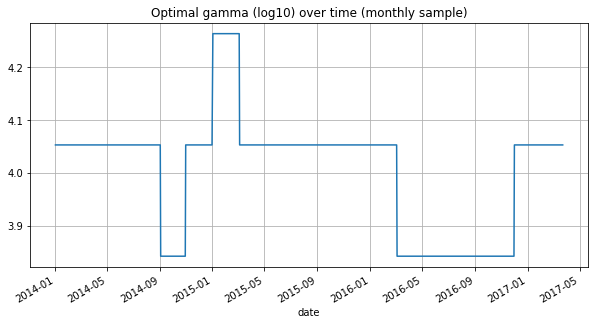

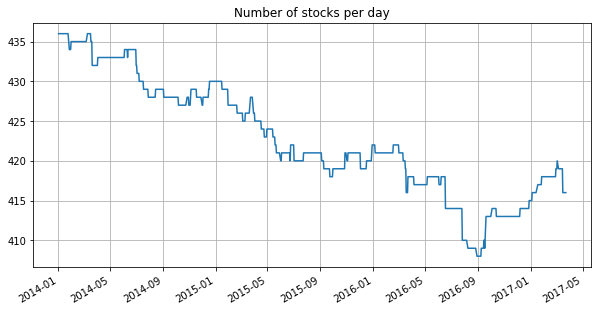

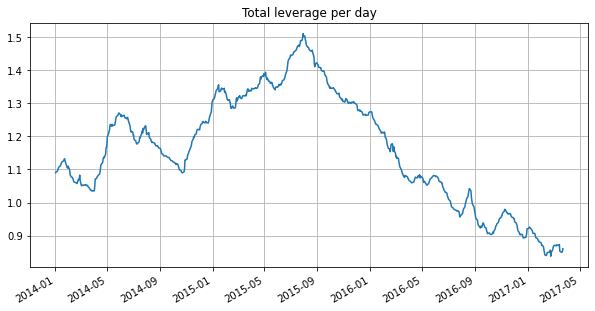

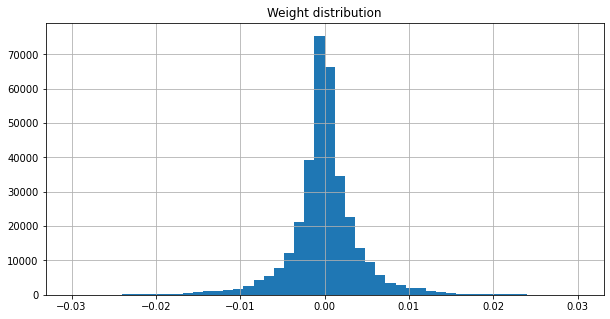

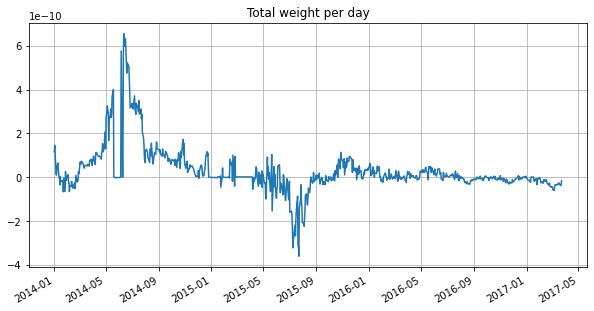

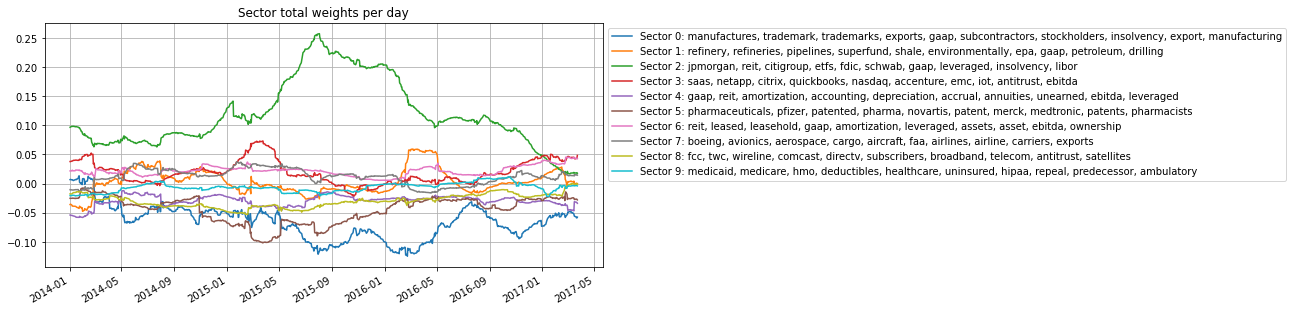

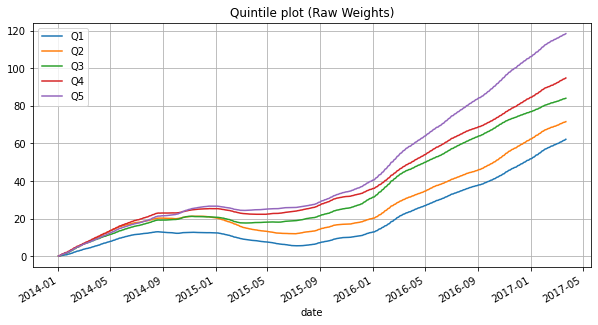

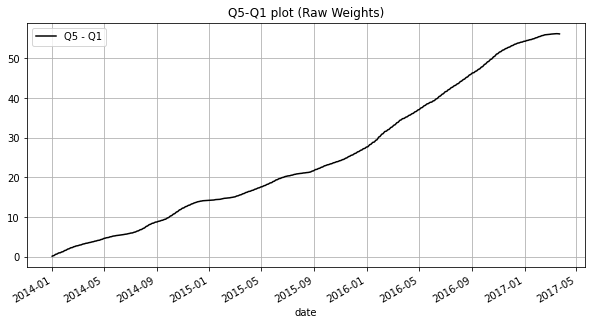

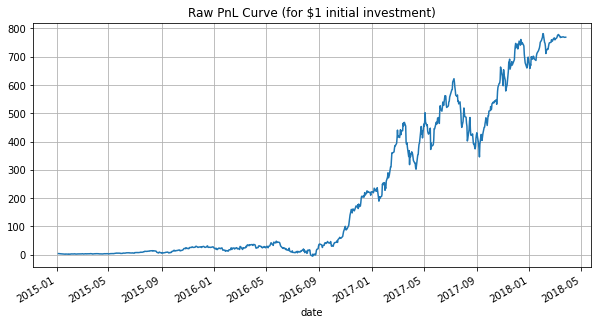

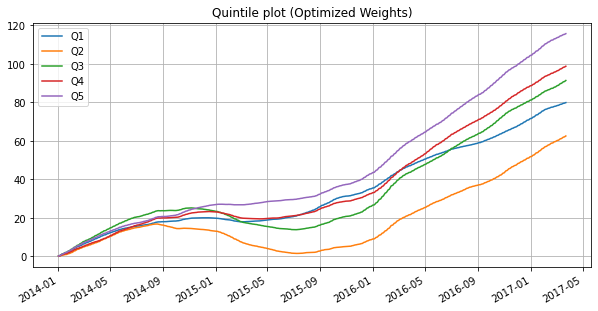

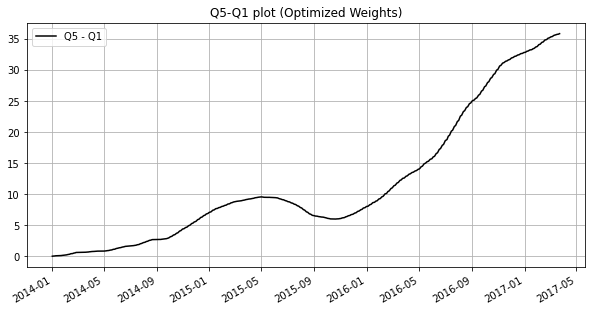

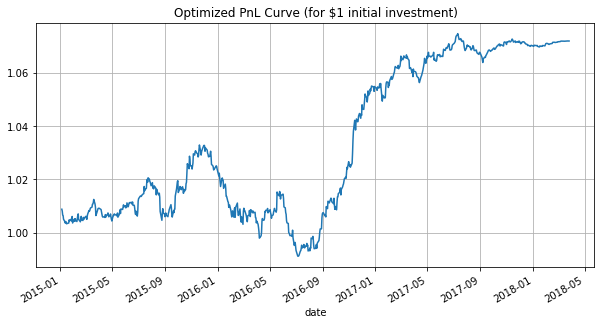

[2022-05-16 18:42:13] Selected signal : feat_weighted_avg_s0_k0.5_uniform
[2022-05-16 18:42:13] Selected horizon : 12m
[2022-05-16 18:42:13] Selected n-days horizon : 252
[2022-05-16 18:42:13] Mean optimized gamma: 10418.945189532367
[2022-05-16 18:42:13] Sector neutral : False
[2022-05-16 18:42:13] Risk model : cov_simple
[2022-05-16 18:42:13] Avg correlation bewteen raw and optimized weights: 0.7346296669186835
[2022-05-16 18:42:13] Raw Sharpe : 2.1736637564435575
[2022-05-16 18:42:13] Optimized Sharpe : 0.8565685622579071


In [11]:
'''
Simple risk model (only use stocks' individual volotility as risk)
Allow active sector positions
'''
weights_raw, port_ret_raw, weights_opt, port_ret_opt = optimize(ret, exret, spy, betas, 'feat_weighted_avg_s0_k0.5_uniform', '12m', 'cov_simple', False, True)

[2022-05-16 18:42:22] Number of stocks in ret, beta: 605
[2022-05-16 18:42:23] Shape of signal: (812, 549)


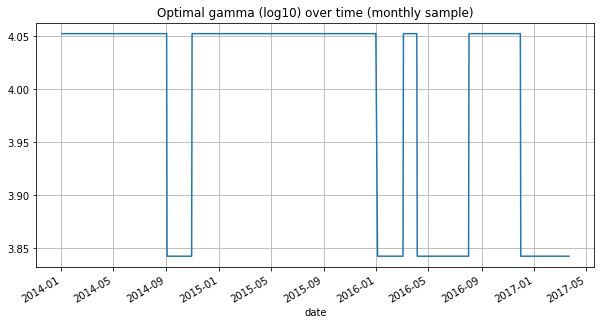

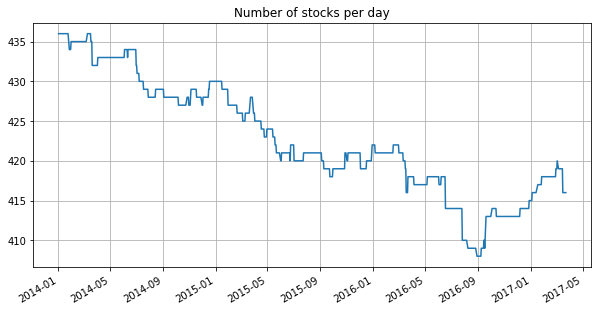

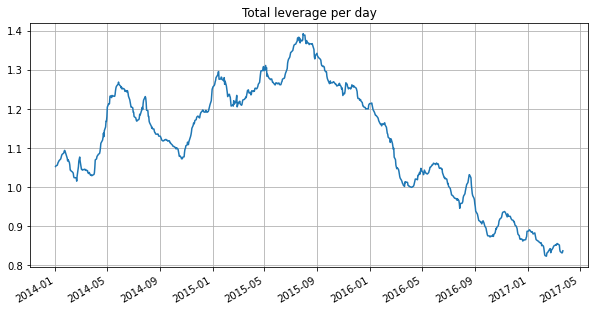

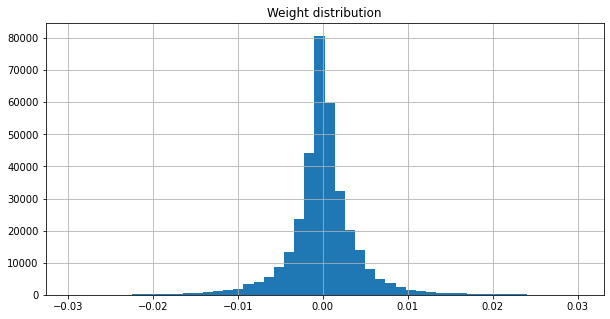

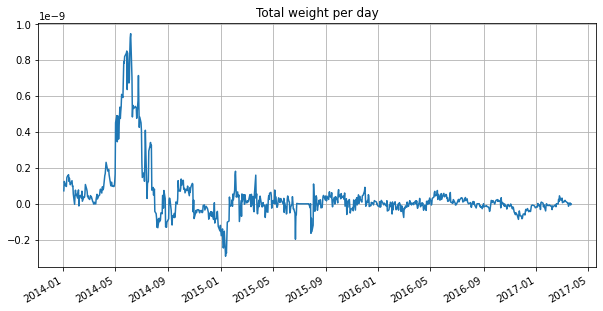

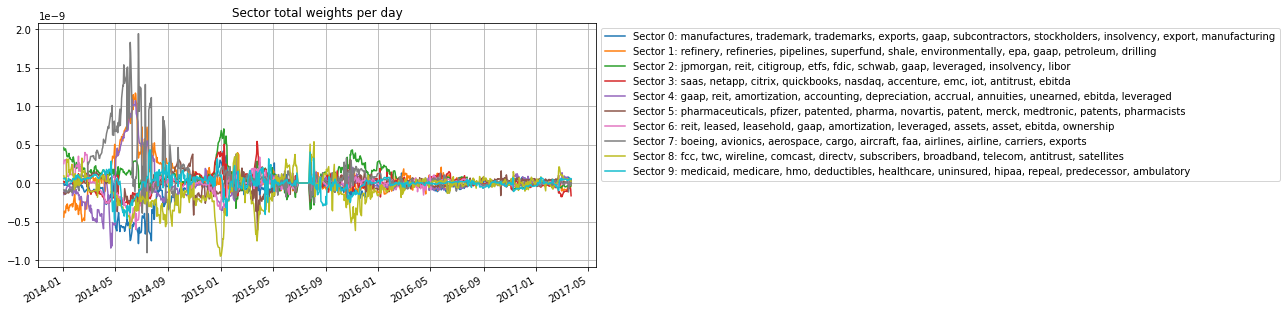

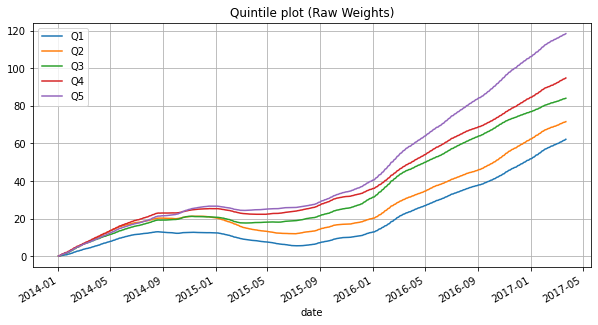

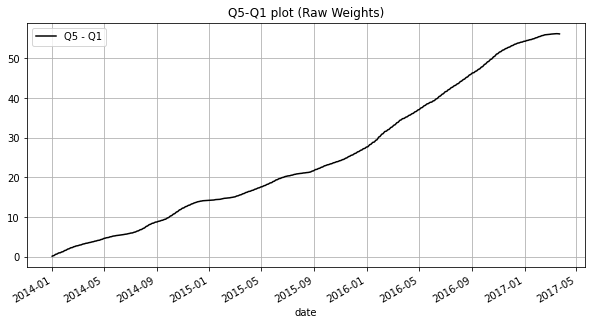

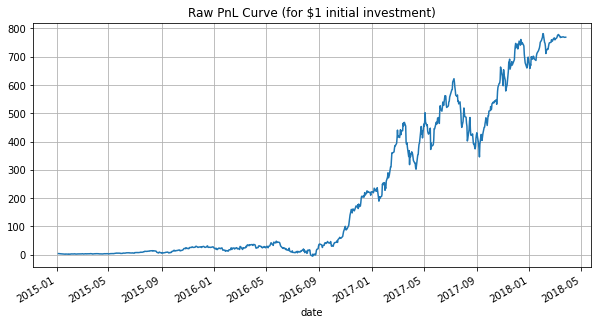

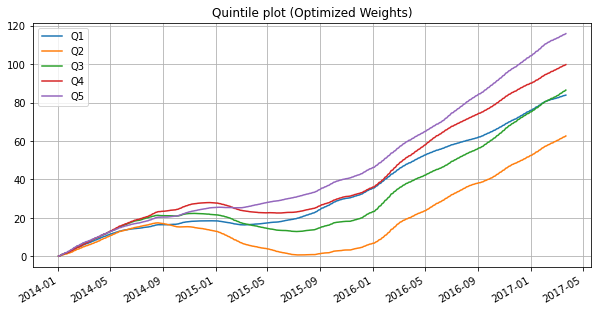

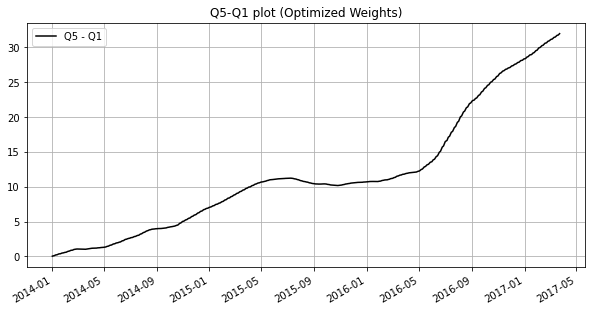

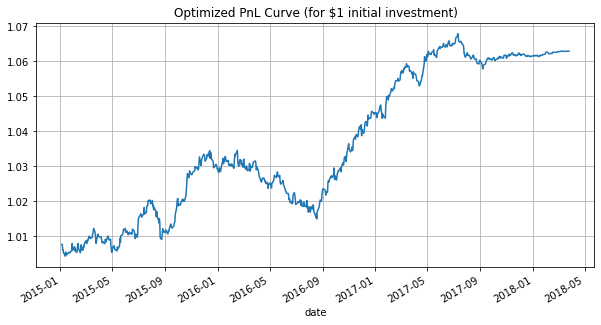

[2022-05-16 18:43:21] Selected signal : feat_weighted_avg_s0_k0.5_uniform
[2022-05-16 18:43:21] Selected horizon : 12m
[2022-05-16 18:43:21] Selected n-days horizon : 252
[2022-05-16 18:43:21] Mean optimized gamma: 9979.966990747851
[2022-05-16 18:43:21] Sector neutral : True
[2022-05-16 18:43:21] Risk model : cov_simple
[2022-05-16 18:43:21] Avg correlation bewteen raw and optimized weights: 0.7032172559478307
[2022-05-16 18:43:21] Raw Sharpe : 2.1736637564435575
[2022-05-16 18:43:21] Optimized Sharpe : 1.2333453873326754


In [12]:
'''
Simple risk model (only use stocks' individual volotility as risk)
Forcing sector neutrality
'''
weights_raw, port_ret_raw, weights_opt, port_ret_opt = optimize(ret, exret, spy, betas, 'feat_weighted_avg_s0_k0.5_uniform', '12m', 'cov_simple', True, True)

[2022-05-16 18:43:32] Number of stocks in ret, beta: 605
[2022-05-16 18:43:33] Shape of signal: (812, 549)


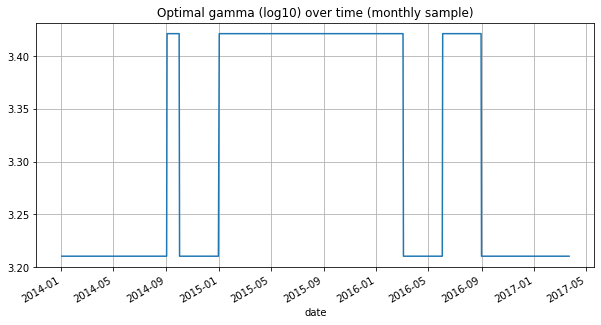

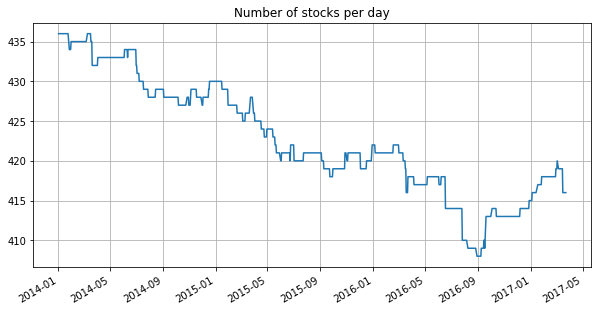

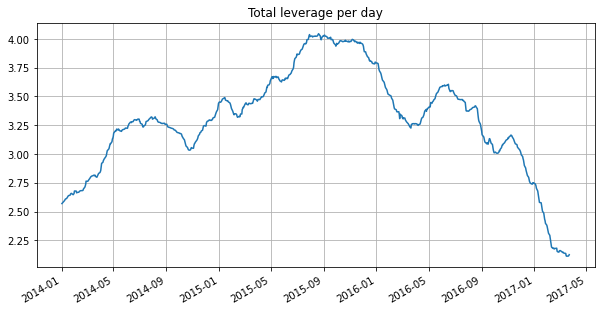

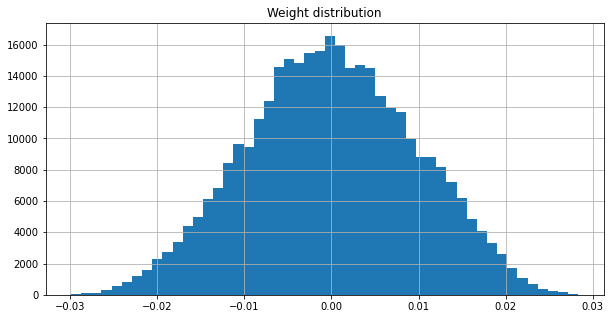

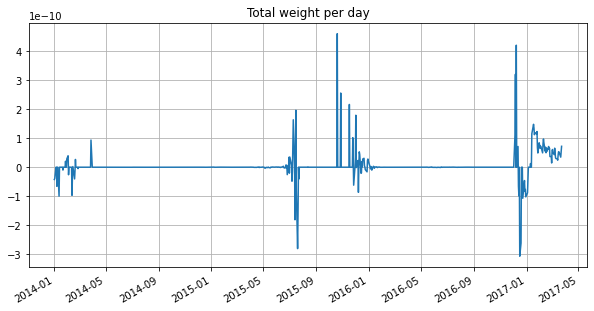

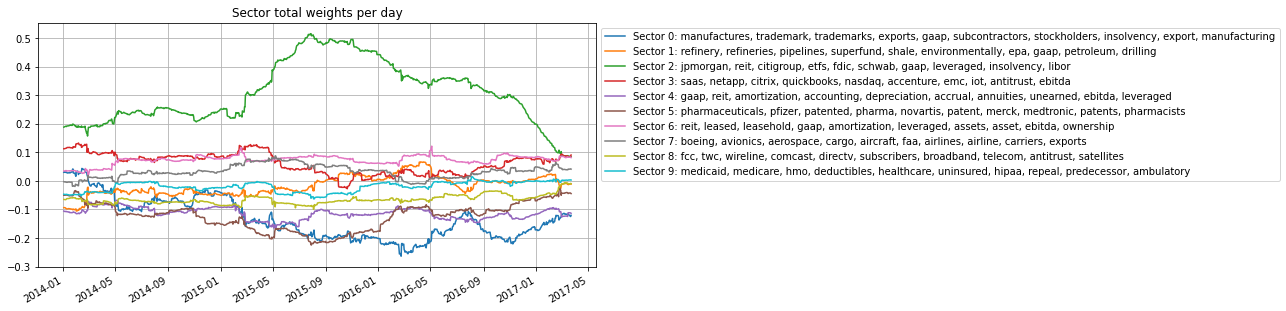

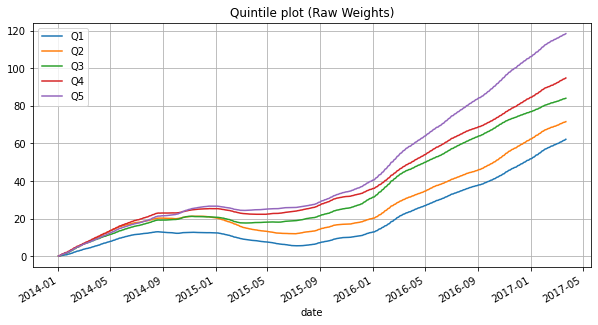

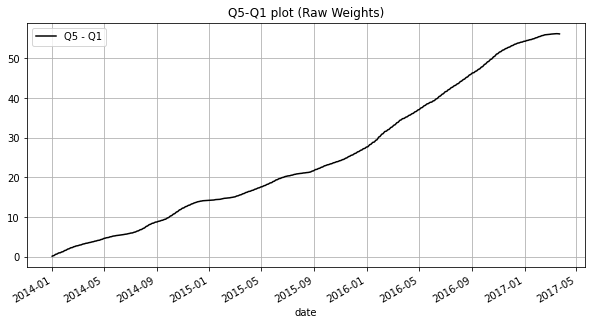

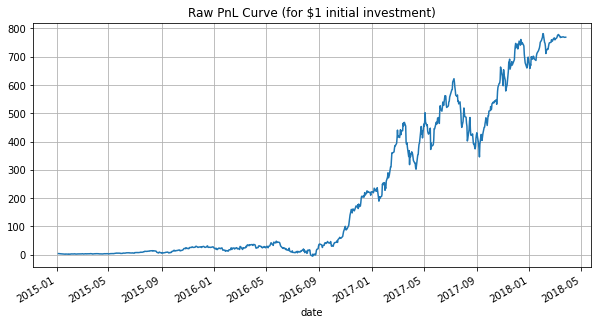

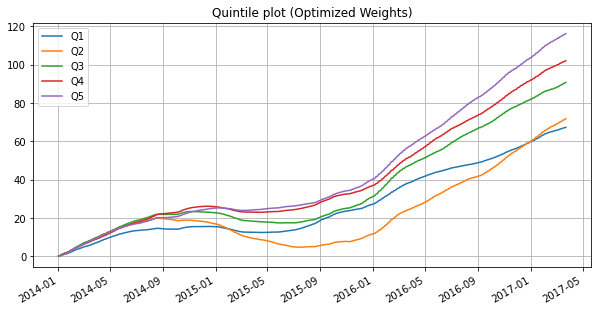

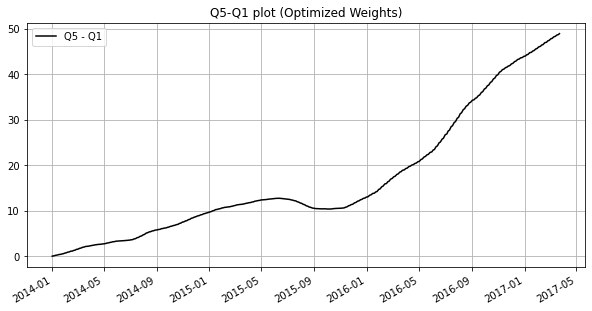

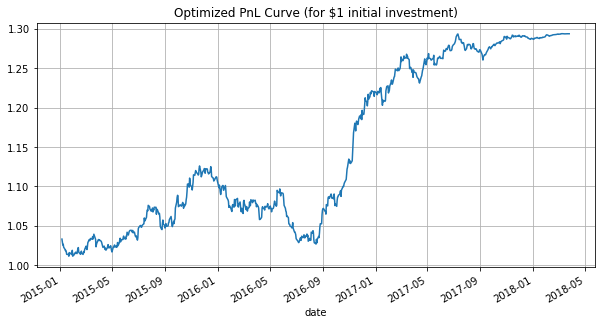

[2022-05-16 18:46:09] Selected signal : feat_weighted_avg_s0_k0.5_uniform
[2022-05-16 18:46:09] Selected horizon : 12m
[2022-05-16 18:46:09] Selected n-days horizon : 252
[2022-05-16 18:46:09] Mean optimized gamma: 2095.287123802937
[2022-05-16 18:46:09] Sector neutral : False
[2022-05-16 18:46:09] Risk model : cov_mkt_risk
[2022-05-16 18:46:09] Avg correlation bewteen raw and optimized weights: 0.9380392690073353
[2022-05-16 18:46:09] Raw Sharpe : 2.1736637564435575
[2022-05-16 18:46:09] Optimized Sharpe : 1.2342015128918284


In [13]:
'''
1-Factor (market risk factor) risk model
Allow active sector positions
'''
weights_raw, port_ret_raw, weights_opt, port_ret_opt = optimize(ret, exret, spy, betas, 'feat_weighted_avg_s0_k0.5_uniform', '12m', 'cov_mkt_risk', False, True)

[2022-05-16 18:46:18] Number of stocks in ret, beta: 605
[2022-05-16 18:46:19] Shape of signal: (812, 549)


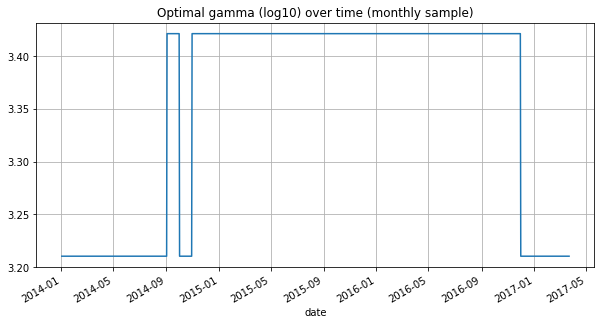

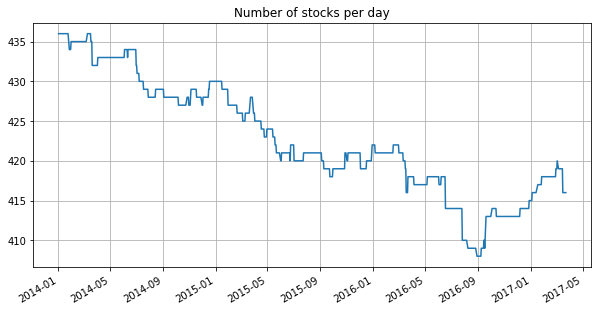

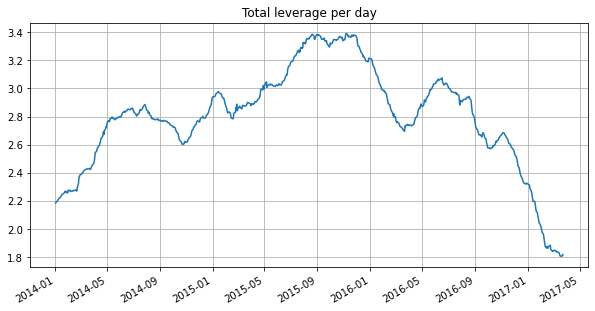

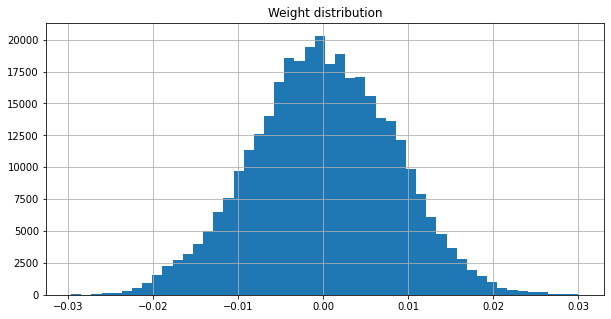

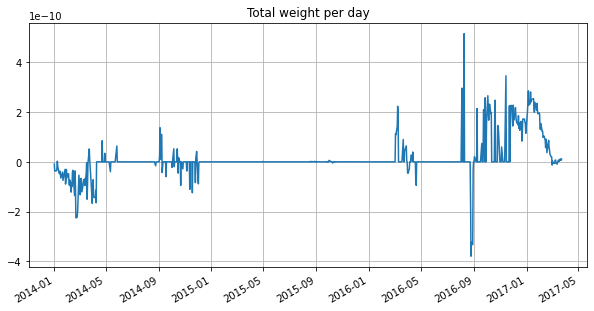

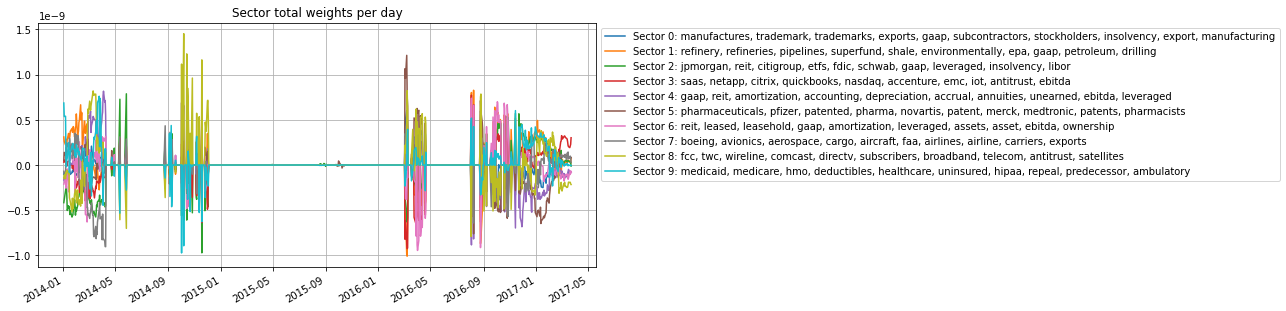

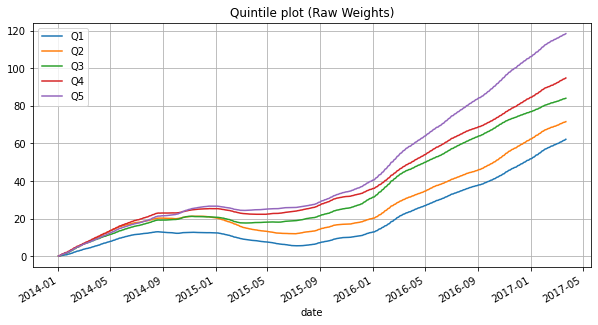

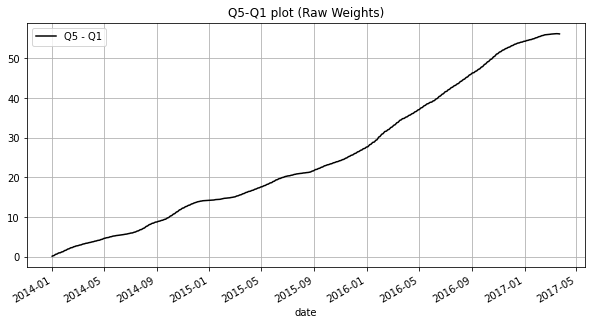

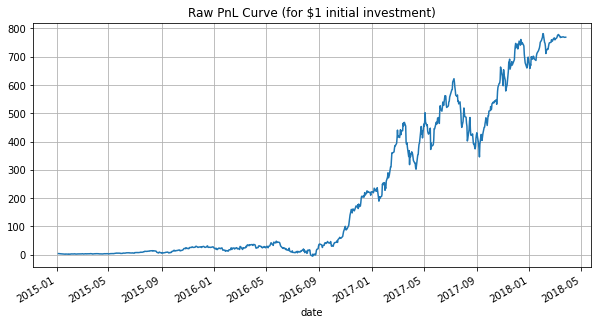

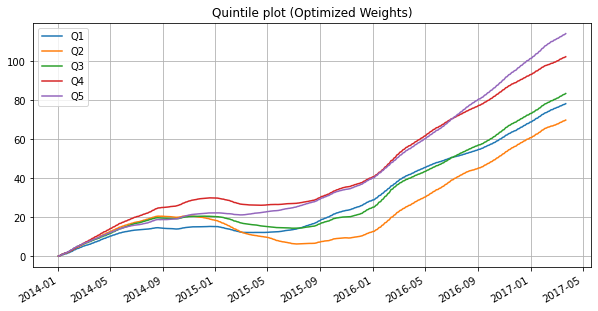

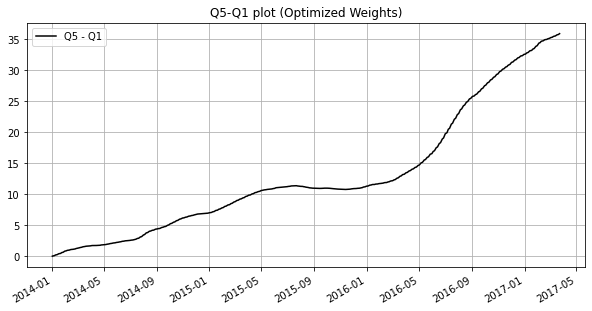

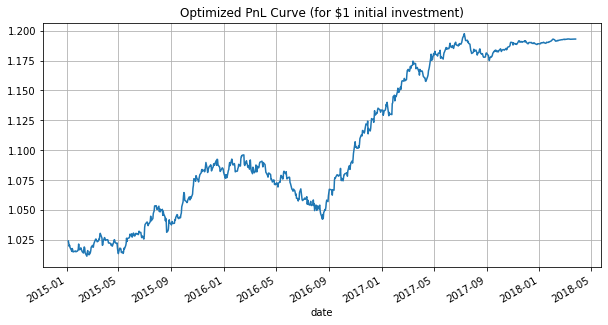

[2022-05-16 18:48:58] Selected signal : feat_weighted_avg_s0_k0.5_uniform
[2022-05-16 18:48:58] Selected horizon : 12m
[2022-05-16 18:48:58] Selected n-days horizon : 252
[2022-05-16 18:48:58] Mean optimized gamma: 2304.847294742595
[2022-05-16 18:48:58] Sector neutral : True
[2022-05-16 18:48:58] Risk model : cov_mkt_risk
[2022-05-16 18:48:58] Avg correlation bewteen raw and optimized weights: 0.8897886296784139
[2022-05-16 18:48:58] Raw Sharpe : 2.1736637564435575
[2022-05-16 18:48:58] Optimized Sharpe : 1.500823276368705


In [14]:
'''
1-Factor (market risk factor) risk model
Forcing sector neutrality
'''
weights_raw, port_ret_raw, weights_opt, port_ret_opt = optimize(ret, exret, spy, betas, 'feat_weighted_avg_s0_k0.5_uniform', '12m', 'cov_mkt_risk', True, True)